In [21]:
# Imports
import torchcrepe
import numpy as np
import pretty_midi
import sounddevice as sd
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf

# Custom Helpers
from audio_helpers import render_midi

In [23]:
audio, sr = torchcrepe.load.audio("./data/BDCT-0/4YNW3G/Audio Files/Nord.02 L.08_01.wav")
print(f"Before: {audio.shape}")
audio = audio.mean(dim=0, keepdim=True)
print(f"After: {audio.shape}")

Before: torch.Size([1, 11234852])
After: torch.Size([1, 11234852])


In [85]:
# Load audio
# audio, sr = torchcrepe.load.audio("./data/BDCT-0/4YNW3G/Audio Files/Bass.08_01.wav")
audio, sr = torchcrepe.load.audio("./local/A melody ig copy.m4a")
print(f"Before: {audio.shape}")
audio = audio.mean(dim=0, keepdim=True) # for if there is 2
print(f"After: {audio.shape}")

# Here we'll use a 5 millisecond hop length
hop_length = int(sr / 200.)

# Provide a sensible frequency range for your domain (upper limit is 2006 Hz)
# This would be a reasonable range for speech
fmin = 50
fmax = 550

# Select a model capacity--one of "tiny" or "full"
model = 'tiny'

# Choose a device to use for inference
device = 'mps:0'

# Pick a batch size that doesn't cause memory errors on your gpu
batch_size = 2048

# Compute pitch using first gpu
pitch, periodicity = torchcrepe.predict(audio,
                           sr,
                           hop_length,
                           fmin,
                           fmax,
                           model,
                           batch_size=batch_size,
                           device=device, return_periodicity=True)

Before: torch.Size([1, 7184384])
After: torch.Size([1, 7184384])


In [86]:
# We'll use a 15 millisecond window assuming a hop length of 5 milliseconds
win_length = 3

# Median filter noisy confidence value
new_periodicity = torchcrepe.filter.median(periodicity, win_length)
new_periodicity = torchcrepe.threshold.Silence(-120.)(new_periodicity,
                                                 audio,
                                                 sr,
                                                 hop_length)

# Remove inharmonic regions
new_pitch = torchcrepe.threshold.At(.5)(pitch, new_periodicity)

# Optionally smooth pitch to remove quantization artifacts
new_pitch = torchcrepe.filter.mean(new_pitch, win_length)

In [87]:
# convert to np
pitch_hz = new_pitch.squeeze().cpu().numpy()

crepe_pm = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)
frame_time = hop_length / sr

# filter negatives
threshold = 0.5
voiced = pitch_hz > 0
midi_values = np.full_like(pitch_hz, np.nan, dtype=float)
midi_values[voiced] = librosa.hz_to_midi(pitch_hz[voiced])

current_note = None
start_time = 0.0

for i, v in enumerate(midi_values):
    if voiced[i]:
        if current_note is None: # handle new note
            current_note = int(round(v))
            start_time = i * frame_time
        elif abs(v - current_note) > threshold:
            end_time = i * frame_time
            instrument.notes.append(
                pretty_midi.Note(velocity=100, pitch=current_note, start=start_time, end=end_time))
            current_note = int(round(v))
            start_time = i * frame_time
    else:
        if current_note is not None:
            # end note if silence
            end_time = i * frame_time
            instrument.notes.append(
                pretty_midi.Note(velocity=100, pitch=current_note, start=start_time, end=end_time))
            current_note = None

# close last note
if current_note is not None:
    end_time = len(pitch_hz) * frame_time
    instrument.notes.append(
        pretty_midi.Note(velocity=100, pitch=current_note, start=start_time, end=end_time))

crepe_pm.instruments.append(instrument)

In [89]:
import numpy as np
import scipy.signal

# Convert to numpy
pitch_hz = new_pitch.squeeze().cpu().numpy()

crepe_pm = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)
frame_time = hop_length / sr

# Filter negatives and convert to MIDI
voiced = pitch_hz > 0
midi_values = np.full_like(pitch_hz, np.nan, dtype=float)
midi_values[voiced] = librosa.hz_to_midi(pitch_hz[voiced])

# Apply additional smoothing to MIDI values to reduce jitter
# Use a larger window for more stable pitch tracking
smooth_window = 9  # 45ms at 5ms hop
midi_smoothed = np.full_like(midi_values, np.nan)
valid_mask = ~np.isnan(midi_values)
if np.any(valid_mask):
    # Only smooth valid (voiced) regions
    midi_smoothed[valid_mask] = scipy.signal.medfilt(midi_values[valid_mask], smooth_window)

# Parameters for note segmentation
pitch_threshold = 1.5  # Increased from 0.5 - more tolerant of pitch variation
min_note_duration = 0.05  # 50ms minimum note duration
min_gap_duration = 0.03  # 30ms minimum gap to split notes

# Improved note segmentation with hysteresis
notes = []
current_note = None
start_time = None
note_pitches = []  # Collect pitches for averaging

for i, midi_val in enumerate(midi_smoothed):
    time = i * frame_time

    if not np.isnan(midi_val):  # Voiced frame
        if current_note is None:
            # Start new note
            current_note = midi_val
            start_time = time
            note_pitches = [midi_val]
        else:
            # Check if pitch changed significantly
            median_pitch = np.median(note_pitches)
            if abs(midi_val - median_pitch) > pitch_threshold:
                # End current note if it's long enough
                if time - start_time >= min_note_duration:
                    notes.append({
                        'pitch': int(round(median_pitch)),
                        'start': start_time,
                        'end': time,
                        'velocity': 100
                    })
                # Start new note
                current_note = midi_val
                start_time = time
                note_pitches = [midi_val]
            else:
                # Continue current note
                note_pitches.append(midi_val)
    else:  # Unvoiced frame
        if current_note is not None:
            # Check if gap is long enough to end note
            # Look ahead to see if voice returns soon
            look_ahead = min(i + int(min_gap_duration / frame_time), len(midi_smoothed) - 1)
            if np.all(np.isnan(midi_smoothed[i:look_ahead])):
                # Gap is long enough, end note
                if time - start_time >= min_note_duration:
                    median_pitch = np.median(note_pitches)
                    notes.append({
                        'pitch': int(round(median_pitch)),
                        'start': start_time,
                        'end': time,
                        'velocity': 100
                    })
                current_note = None
                note_pitches = []

# Close last note if exists
if current_note is not None and start_time is not None:
    time = len(midi_smoothed) * frame_time
    if time - start_time >= min_note_duration:
        median_pitch = np.median(note_pitches)
        notes.append({
            'pitch': int(round(median_pitch)),
            'start': start_time,
            'end': time,
            'velocity': 100
        })

# Add notes to instrument
for note in notes:
    instrument.notes.append(
        pretty_midi.Note(
            velocity=note['velocity'],
            pitch=note['pitch'],
            start=note['start'],
            end=note['end']
        )
    )

crepe_pm.instruments.append(instrument)

In [90]:
render_midi(crepe_pm)

In [84]:
gen_audio = generate_audio_midi(crepe_pm, 16000)
sf.write("Bass.08_01_pitch_to_note.wav", gen_audio, 16000)

ValueError: x and y must have same first dimension, but have shapes (1,) and (46812,)

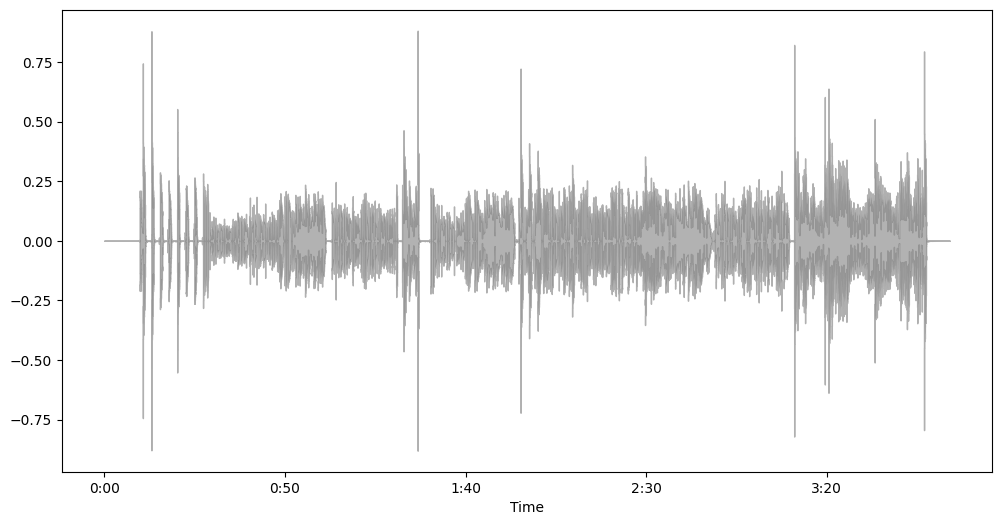

In [59]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Assuming:
# audio: 1D NumPy array or tensor
# pitch: 1D NumPy array of f0 in Hz
# sr, hop_length defined

cleaned_audio = audio.squeeze().cpu().numpy()
cleaned_pitch = pitch.squeeze().cpu().numpy()
times = np.arange(len(pitch)) * hop_length / sr

plt.figure(figsize=(12, 6))
librosa.display.waveshow(cleaned_audio, sr=sr, alpha=0.6, color='gray')
plt.plot(times, cleaned_pitch / np.max(cleaned_pitch) * np.max(cleaned_audio), color='deepskyblue', linewidth=2)
plt.title("Waveform + Normalized Pitch Contour")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [29]:
import numpy as np
import librosa

pitch_hz = pitch.squeeze().cpu().numpy()
# pitch_hz = pitch

# voiced mask: only frames with real pitch
voiced = pitch_hz > 0

midi = np.empty_like(pitch_hz, dtype=float)
midi[:] = np.nan
midi[voiced] = librosa.hz_to_midi(pitch_hz[voiced])

# convert only voiced frames to note names
note_names = np.empty_like(pitch_hz, dtype=object)
note_names[:] = None
note_names[voiced] = librosa.midi_to_note(midi[voiced])

# e.g. filter out silence if you just want a list of notes
notes_compact = librosa.midi_to_note(midi[voiced])

In [30]:
notes_compact

array(['G3', 'G3', 'G3', ..., 'C4', 'C4', 'C4'], dtype='<U3')